In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import saqqara
import sys
sys.path.insert(0, '../inference/')
sys.path.insert(0, '../simulator/')
from networks import SignalAET
from simulator import LISA_AET
from dataloader import get_datasets, setup_dataloaders, get_data_npy_dataset
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import pickle
import swyft
import logging
import tqdm
log = logging.getLogger("pytorch_lightning")
log.propagate = False
log.setLevel(logging.ERROR)

In [3]:
from scipy.integrate import simps
from scipy.interpolate import interp1d
def get_sigmas(logratios):
    lrs = np.array(logratios.logratios[:, 0].reshape(int(np.sqrt(logratios.logratios.shape[0])), int(np.sqrt(logratios.logratios.shape[0]))))
    params_alpha = np.array(logratios.params[:, 0, 0].reshape(int(np.sqrt(logratios.params.shape[0])), int(np.sqrt(logratios.params.shape[0]))))
    params_gamma = np.array(logratios.params[:, 0, 1].reshape(int(np.sqrt(logratios.params.shape[0])), int(np.sqrt(logratios.params.shape[0]))))
    posterior = np.exp(lrs - np.max(lrs)) / np.sum(np.exp(lrs - np.max(lrs))) / (params_alpha[1, 0] - params_alpha[0, 0]) * (params_gamma[0, 1] - params_gamma[0, 0])
    alpha_marginal = simps(posterior, params_gamma, axis=1)
    gamma_marginal = simps(posterior, params_alpha, axis=0)
    alpha_ps = params_alpha[:, 0]
    gamma_ps = params_gamma[0, :]
    norm_alpha_marginal = alpha_marginal / simps(alpha_marginal, alpha_ps) 
    norm_gamma_marginal = gamma_marginal / simps(gamma_marginal, gamma_ps)
    alpha_cumulant =  np.cumsum(norm_alpha_marginal * (alpha_ps[1] - alpha_ps[0]))
    gamma_cumulant =  np.cumsum(norm_gamma_marginal * (gamma_ps[1] - gamma_ps[0]))
    alpha_interp = interp1d(alpha_cumulant, alpha_ps)
    gamma_interp = interp1d(gamma_cumulant, gamma_ps)
    alpha_sigma = 0.5 * (alpha_interp(0.5 + 0.34) - alpha_interp(0.5 - 0.34))
    gamma_sigma = 0.5 * (gamma_interp(0.5 + 0.34) - gamma_interp(0.5 - 0.34))
    return alpha_sigma, gamma_sigma

def get_resampling_dataset(sim, settings, path_to_data=None):
    training_settings = settings.get("train", {})
    if training_settings["type"] != "resampling":
        raise ValueError("Training type must be resampling")
    data_dir = training_settings.get("store_name") if path_to_data is None else path_to_data + training_settings.get("store_name")
    store_dataset = get_data_npy_dataset(data_dir)
    resampling_dataset = saqqara.RandomSamplingDataset(
        store_dataset,
        shuffle=training_settings.get("shuffle", True),
    )
    dataset = saqqara.ResamplingTraining(sim, resampling_dataset)
    return dataset

def get_grid(N=1000, a_low=-11.42961597442627, a_high=-10.696080207824707, g_low=-0.7066106200218201, g_high=1.0477334260940552):
    a_samples = np.linspace(a_low, a_high, N)
    g_samples = np.linspace(g_low, g_high, N)
    ag_samples = np.array(np.meshgrid(a_samples, g_samples)).T.reshape(-1, 2)
    A_samples = np.ones(N)
    P_samples = np.ones(N)
    AP_samples = np.array(np.meshgrid(A_samples, P_samples)).T.reshape(-1, 2)
    return swyft.Samples(z=np.float32(np.concatenate((ag_samples, AP_samples), axis=1)))

def get_network(id, sim):
    config = glob.glob(f"../training_dir/training_config_id={id}.yaml")[0]
    ckpt = glob.glob(f"../training_dir/saqqara-*_id={id}.ckpt")[0]
    settings = saqqara.load_settings(config_path=config)
    network = SignalAET(settings=settings, sim=sim)
    network = saqqara.load_state(network=network, ckpt=ckpt)
    return network

In [4]:
id = "G7RG"
config = glob.glob(f"../training_dir/training_config_id={id}.yaml")[0]
ckpt = glob.glob(f"../training_dir/saqqara-*_id={id}.ckpt")[0]
settings = saqqara.load_settings(config_path=config)
sim = LISA_AET(settings)
network = get_network(id, sim)
trainer = saqqara.setup_trainer(settings, logger=None)
dataset = get_resampling_dataset(sim, settings, path_to_data='../')

Detector setup complete
Noise matrices computed
Response computed
Coarse graining setup complete
[INFO] Loading data from ../data/resampling_three_channel
[INFO] Total number of simulations: 51200
data shape: (6, 1779, 3)


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(


In [8]:
def get_cumulative_dist(sample):
    dist = []
    for pt in np.linspace(0, 1, 1000):
        dist.append(len(sample[sample < pt]) / len(sample))
    return np.array(dist)
dists = np.vstack([get_cumulative_dist(np.random.uniform(0, 1, 200)) for _ in tqdm.tqdm(range(4000))])

  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [00:06<00:00, 574.86it/s]


In [12]:
prior_samples = swyft.Samples(z=torch.tensor(sim.prior.sample(10_000)).float())
coverage_data = dataset.sample(z=sim.prior.sample(4000))
dm = swyft.Samples(z=torch.tensor(coverage_data['z']).float(), data=torch.tensor(coverage_data['data']).float())
coverage_samples = trainer.test_coverage(get_network(id="G7RG", sim=sim), dm, prior_samples, batch_size=100000)

/tmp/ipykernel_1834435/2744605709.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dm = swyft.Samples(z=torch.tensor(coverage_data['z']).float(), data=torch.tensor(coverage_data['data']).float())
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 4000/4000 [03:05<00:00, 21.60it/s]


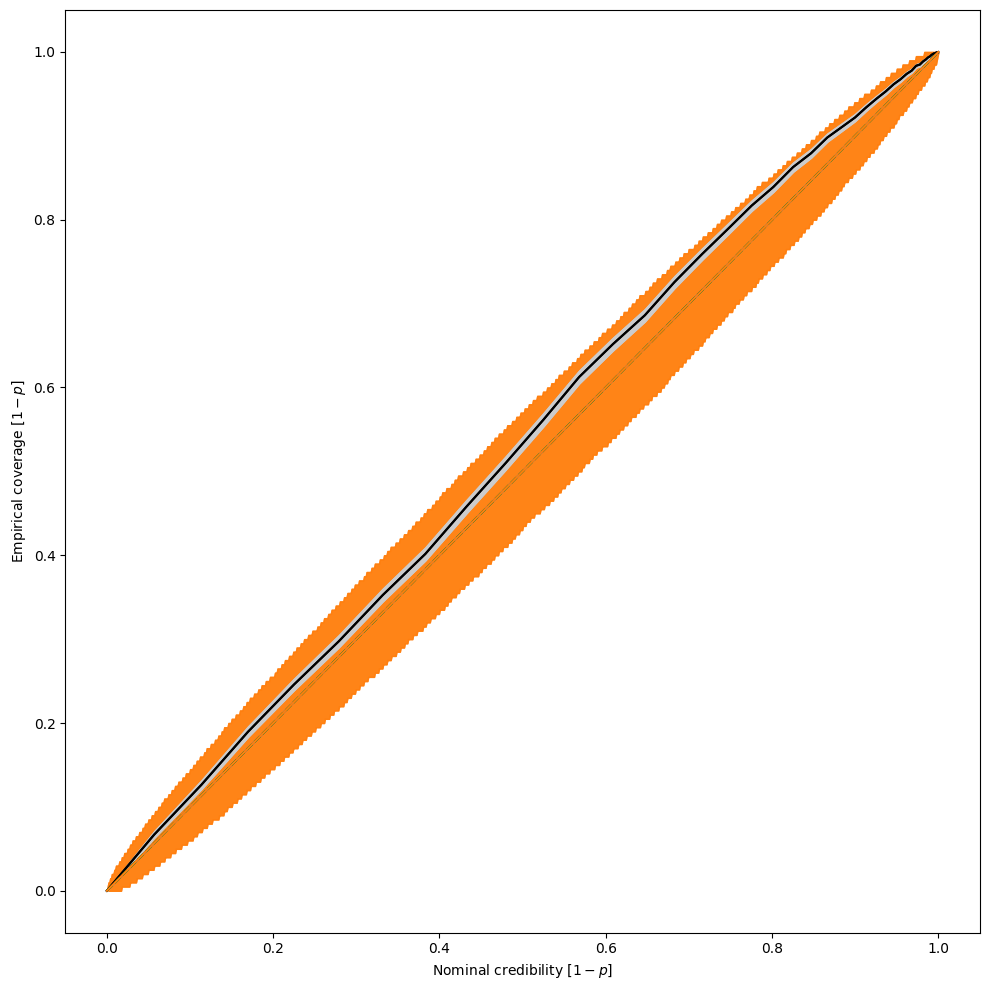

In [13]:
fig, axes = plt.subplots(1, 1, figsize = (10, 10))
for i in range(2):
    ax = axes
    ax.plot([0, 0], [1, 1], c='r')
    swyft.plot_pp(coverage_samples, ['z[0]', 'z[1]'], ax = axes)
    axes.plot([0.0, 1.0], [0.0, 1.0])
    axes.fill_between(np.linspace(0, 1, 1000), y1=np.quantile(dists, q=[0.025], axis=0)[0], y2=np.quantile(dists, q=[0.975], axis=0)[0], color='C1', alpha=0.8, zorder=-10)
plt.tight_layout()

In [14]:
pickle.dump(coverage_samples, open("../results/full_inference/coverage_samples.pkl", "wb"))